In [41]:
%matplotlib inline

import os
import io

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from PIL import Image, ImageFilter

from IPython.display import display

import zipfile

import cv2

from tqdm import tqdm

import tensorflow as tf
import time

In [42]:
RANDOM_SEED = 42

IMG_WIDTH = 75
IMG_HEIGHT = 75
IMG_CHANNELS = 1

IMG_SHAPE = [IMG_WIDTH, IMG_HEIGHT]
IMG_LENGTH = IMG_WIDTH * IMG_HEIGHT

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
def label_img(img_name):
  if 'cat' in img_name: return [1, 0]
  elif 'dog' in img_name: return [0, 1]

In [45]:
training_data = []

with zipfile.ZipFile('/content/drive/My Drive/train.zip', 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (IMG_WIDTH, IMG_HEIGHT))

      training_data.append([ np.array(img), np.array(label)])

100%|██████████| 25001/25001 [00:37<00:00, 671.29it/s]


In [46]:
training_data[0]

[array([[170, 174, 181, ..., 214, 210, 206],
        [170, 174, 181, ..., 216, 212, 208],
        [170, 175, 181, ..., 217, 215, 210],
        ...,
        [129, 133, 135, ...,   3,   3,   2],
        [127, 129, 131, ...,   3,   3,   2],
        [124, 128, 131, ...,   2,   2,   2]], dtype=uint8), array([1, 0])]

In [47]:
def peek_img( index, data = training_data):
  img_type = 'Unknown'
  
  if np.array_equal(data[index][1], [1, 0]): img_type = 'Cat'
  elif np.array_equal(data[index][1], [0, 1]): img_type = 'Dog'
  
  imshow(data[index][0], cmap = 'gray', interpolation = 'bicubic')
  plt.title(img_type)
  plt.show()

In [48]:
training_data[0][0]

array([[170, 174, 181, ..., 214, 210, 206],
       [170, 174, 181, ..., 216, 212, 208],
       [170, 175, 181, ..., 217, 215, 210],
       ...,
       [129, 133, 135, ...,   3,   3,   2],
       [127, 129, 131, ...,   3,   3,   2],
       [124, 128, 131, ...,   2,   2,   2]], dtype=uint8)

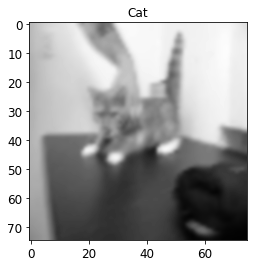

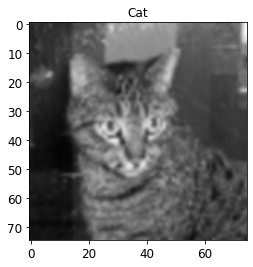

In [49]:
peek_img(0)
peek_img(1)

In [50]:
dog_index = -1

for i, x in enumerate(training_data):
  if np.array_equal(x[1], [0, 1]):
    dog_index = i
    break

dog_index

12500

In [51]:
def plot_images(images, cls_true, indexes = None, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=1.3)

    for i, ax in enumerate(axes.flat):

        ax.imshow(images[i].reshape(IMG_SHAPE), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        if indexes != None:
          ax.set_ylabel(indexes[i])
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [52]:
def plot_indexes(indexes):
  subset = [training_data[i] for i in indexes]

  images = []
  labels = []

  for i in subset:
    x, y = i

    images.append(x)

    if np.array_equal(y, [1, 0]): labels.append('Cat')
    elif np.array_equal(y, [0, 1]): labels.append('Dog')

  plot_images(images, labels, indexes)

In [53]:
import random

indexes = []

for x in range(9):
  indexes.append(random.randint(0, len(training_data)))

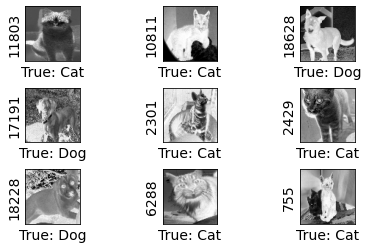

In [54]:
plot_indexes(indexes)

In [55]:
from random import shuffle 

shuffle(training_data)

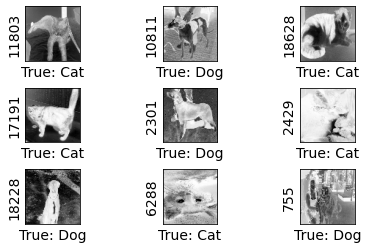

In [56]:
plot_indexes(indexes)

In [57]:
train_size = int(len(training_data) * .8)
train_size

20000

In [58]:
train = training_data[-train_size:]
display('Train Size: {}'.format(len(train)))

test = training_data[:-train_size]
display('Test Size: {}'.format(len(test)))

'Train Size: 20000'

'Test Size: 5000'

In [59]:
X_train = np.array([i[0] for i in train]).reshape(-1,IMG_WIDTH, IMG_HEIGHT,1)
y_train = np.array([i[1] for i in train])

In [60]:
X_test = np.array([i[0] for i in test]).reshape(-1,IMG_WIDTH, IMG_HEIGHT,1)
y_test = np.array([i[1] for i in test])

## Deep Classification Model

In [61]:
LR = 1e-3

In [62]:
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic')

In [63]:
pip install tflearn

In [64]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [65]:
def get_model_baseline():
  convnet = input_data(shape=[None, IMG_WIDTH, IMG_HEIGHT, 1], name='input')

  convnet = conv_2d(convnet, 32, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 64, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = fully_connected(convnet, 1024, activation='relu')
  convnet = dropout(convnet, 0.8)

  convnet = fully_connected(convnet, 2, activation='softmax')
  convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

  return tflearn.DNN(convnet, tensorboard_dir='log')

In [83]:
def get_model_v2():
  convnet = input_data(shape=[None, IMG_WIDTH, IMG_HEIGHT, 1], name='input')

  convnet = conv_2d(convnet, 32, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 64, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 128, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 64, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 32, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = fully_connected(convnet, 1024, activation='relu')
  convnet = dropout(convnet, 0.8)

  convnet = fully_connected(convnet, 2, activation='softmax')
  convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

  return tflearn.DNN(convnet, tensorboard_dir='log') 

In [102]:
def get_model_v3():
  convnet = input_data(shape=[None, IMG_WIDTH, IMG_HEIGHT, 1], name='input')

  convnet = conv_2d(convnet, 32, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 64, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 128, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 64, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 32, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = fully_connected(convnet, 1024, activation='relu')
  convnet = dropout(convnet, 0.8)

  convnet = fully_connected(convnet, 2, activation='softmax')
  convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='sparse_categorical_crossentropy', name='targets')

  return tflearn.DNN(convnet, tensorboard_dir='log') 

In [116]:
def get_model_v4():
  convnet = input_data(shape=[None, IMG_WIDTH, IMG_HEIGHT, 1], name='input')

  convnet = conv_2d(convnet, 32, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 64, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 128, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 64, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 32, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = fully_connected(convnet, 1024, activation='relu')
  convnet = dropout(convnet, 0.8)

  convnet = fully_connected(convnet, 2, activation='softmax')
  convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='kl_divergence', name='targets')

  return tflearn.DNN(convnet, tensorboard_dir='log') 

## Fit the Models

In [76]:
display('Train Size: {}'.format(len(X_train)))

'Train Size: 20000'

In [77]:
display('Model Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model Train Time: 3.43 minutes'

In [73]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

ops.reset_default_graph()

In [74]:
ops.reset_default_graph()

model_baseline = get_model_baseline()

start_time = time.perf_counter()

model_baseline.fit({'input': X_train}, {'targets': y_train}, n_epoch=3, validation_set=({'input': X_test}, {'targets': y_test}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

end_time = time.perf_counter()

runtime = end_time - start_time

Training Step: 938  | total loss: 11.54362 | time: 105.353s
| Adam | epoch: 003 | loss: 11.54362 - acc: 0.4987 -- iter: 19968/20000
Training Step: 939  | total loss: 11.64849 | time: 112.439s
| Adam | epoch: 003 | loss: 11.64849 - acc: 0.4941 | val_loss: 11.44385 - val_acc: 0.5030 -- iter: 20000/20000
--


In [75]:
display('Model Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model Train Time: 3.43 minutes'

## from baseline to v2 fitting


In [79]:
ops.reset_default_graph()

model_v2 = get_model_v2()

start_time = time.perf_counter()

model_v2.fit({'input': X_train}, {'targets': y_train}, n_epoch=3, validation_set=({'input': X_test}, {'targets': y_test}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

end_time = time.perf_counter()

runtime = end_time - start_time

Training Step: 938  | total loss: 0.53032 | time: 125.668s
| Adam | epoch: 003 | loss: 0.53032 - acc: 0.7421 -- iter: 19968/20000
Training Step: 939  | total loss: 0.52403 | time: 133.125s
| Adam | epoch: 003 | loss: 0.52403 - acc: 0.7476 | val_loss: 0.52561 - val_acc: 0.7426 -- iter: 20000/20000
--


In [80]:
display('Model Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model Train Time: 4.06 minutes'

In [100]:
ops.reset_default_graph()

model_v3 = get_model_v3()

start_time = time.perf_counter()

model_v3.fit({'input': X_train}, {'targets': y_train}, n_epoch=3, validation_set=({'input': X_test}, {'targets': y_test}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

end_time = time.perf_counter()

runtime = end_time - start_time

Training Step: 938  | total loss: 0.50022 | time: 128.750s
| Adam | epoch: 003 | loss: 0.50022 - acc: 0.7549 -- iter: 19968/20000
Training Step: 939  | total loss: 0.49452 | time: 136.342s
| Adam | epoch: 003 | loss: 0.49452 - acc: 0.7575 | val_loss: 0.52897 - val_acc: 0.7390 -- iter: 20000/20000
--


In [101]:
display('Model Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model Train Time: 4.12 minutes'

In [114]:
ops.reset_default_graph()

model_v4 = get_model_v4()

start_time = time.perf_counter()

model_v4.fit({'input': X_train}, {'targets': y_train}, n_epoch=3, validation_set=({'input': X_test}, {'targets': y_test}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

end_time = time.perf_counter()

runtime = end_time - start_time

Training Step: 938  | total loss: 0.49765 | time: 127.488s
| Adam | epoch: 003 | loss: 0.49765 - acc: 0.7753 -- iter: 19968/20000
Training Step: 939  | total loss: 0.49213 | time: 135.207s
| Adam | epoch: 003 | loss: 0.49213 - acc: 0.7728 | val_loss: 0.50166 - val_acc: 0.7560 -- iter: 20000/20000
--


In [115]:
display('Model Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model Train Time: 4.11 minutes'

In [117]:
test_data = []

with zipfile.ZipFile('/content/drive/My Drive/test.zip', 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (IMG_WIDTH, IMG_HEIGHT))

      test_data.append([ np.array(img), np.array(label)])

100%|██████████| 12501/12501 [00:19<00:00, 638.37it/s]


In [118]:
import matplotlib.pyplot as plt

def visual_inspect_model( model ):
  fig=plt.figure(figsize=(5,5))
  fig.subplots_adjust(hspace=0.5, wspace=1.3)

  for num,data in enumerate(test_data[:12]):

      img_num = data[1]
      img_data = data[0]

      y = fig.add_subplot(4,3,num+1)
      orig = img_data
      data = img_data.reshape(IMG_WIDTH,IMG_HEIGHT,1)

      model_out = model.predict([data])[0]

      if np.argmax(model_out) == 1: str_label='Dog'
      else: str_label='Cat'

      y.imshow(orig,cmap='gray')
      plt.title(str_label)
      y.axes.get_xaxis().set_visible(False)
      y.axes.get_yaxis().set_visible(False)

  plt.show()

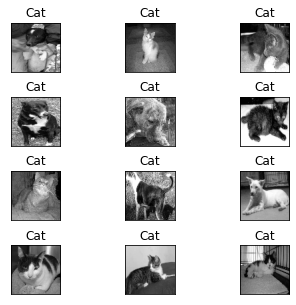

In [119]:
visual_inspect_model(model_baseline)

In [120]:
def validate_model(model):
  total = len(X_test)
  correct = 0

  for num, data in enumerate(X_test):
    y_pred = model.predict([data])[0]

    if np.argmax(y_pred) == 1: img_pred='Dog'
    else: img_pred='Cat'

    if np.array_equal(y_test[num], [1, 0]): img_actual = 'Cat'
    elif np.array_equal(y_test[num], [0, 1]): img_actual = 'Dog'

    if img_actual == img_pred:
      correct = correct + 1

  display('Total Test Images: {}, Correctly Predicted: {}, {:.2%}'.format(total, correct, correct / total))

In [121]:
validate_model(model_baseline)

'Total Test Images: 5000, Correctly Predicted: 2515, 50.30%'

In [122]:
validate_model(model_v2)

'Total Test Images: 5000, Correctly Predicted: 3713, 74.26%'

In [123]:
validate_model(model_v3)

'Total Test Images: 5000, Correctly Predicted: 3695, 73.90%'

In [124]:
validate_model(model_v4)

'Total Test Images: 5000, Correctly Predicted: 3780, 75.60%'

# Conclusion 

# Changing model 2 from categorical_crossentropy to sparse_categorical_crossentropy and then kl_divergence (i.e., Kullback–Leibler divergence) has little difference on processing time and accurancy.

# I would recommend version 2 with categorical_crossentropy given the dataset.